# Notebook of Figure 2 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows the initial conditions used for the idealized simulation used in the study. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
from dask.distributed import Client
import dask
import os

client =Client(n_workers=18, threads_per_worker=1, memory_limit="6 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 18
Total threads: 18,Total memory: 108.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43534,Workers: 18
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 108.00 GiB
Comm: tcp://127.0.0.1:49719,Total threads: 1
Dashboard: http://127.0.0.1:54371/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:34677,


In [3]:
import cmocean as cm

In [4]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc')

In [5]:
# Define dimensions
Nx, Ny, Nz = 801, 1201, 32

X = np.ones((Ny,Nx,Nz)) * grid.x_coord.values[:,:,np.newaxis]
Y = np.ones((Ny,Nx,Nz)) * grid.y_coord.values[:,:,np.newaxis]
Z = -np.ones((Ny,Nx,Nz)) * grid.gdept_1d.sel(nav_lev=slice(0,200)).values[:]

## Init conditions

In [6]:
init_cond="/home1/datahome/jmartine/models/nemo_4.2.0/tests/ICE_CANAL_UHR/EXP_HR/init/hr_canal/"


In [7]:
init_data = xr.open_dataset(init_cond+"HR_channel_oce_noise_front_75m_1_nemo4.nc")

In [8]:
init_data_salt = init_data.vosaline.isel(time=0).transpose("y","x","z").isel(y=slice(1,-1)).sel(z=slice(0,200))

In [9]:
init_data_temp = init_data.votemper.isel(time=0).transpose("y","x","z").isel(y=slice(1,-1)).sel(z=slice(0,200))

In [10]:
def format_3daxis(ax):
    ax.patch.set_alpha(0)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_locator(plt.MaxNLocator(3))
    
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)

    ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

    # Set labels and zticks
    ax.set(
        xlabel='X [km]',
        ylabel='Y [km]',
        zlabel='Depth [m]',
        zticks=[0, -50, -100, -150],
    )

    # Set zoom and angle view
    ax.view_init(40, -60)
    ax.set_box_aspect((1,1.5,0.6), zoom=0.9)
    
def contour_rasterize(contour):
    for pathcoll in contour.collections:
        pathcoll.set_rasterized(True)

In [11]:
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

In [12]:
def axis_to_fig(axis):
    fig = axis.figure
    def transform(coord):
        return fig.transFigure.inverted().transform(
            axis.transAxes.transform(coord))
    return transform

def add_sub_axes(axis, rect,**kwargs):
    fig = axis.figure
    left, bottom, width, height = rect
    trans = axis_to_fig(axis)
    figleft, figbottom = trans((left, bottom))
    figwidth, figheight = trans([width,height]) - trans([0,0])
    return fig.add_axes([figleft, figbottom, figwidth, figheight],**kwargs)

def myfmt(x, pos):
    return '{0:.2f}'.format(x)

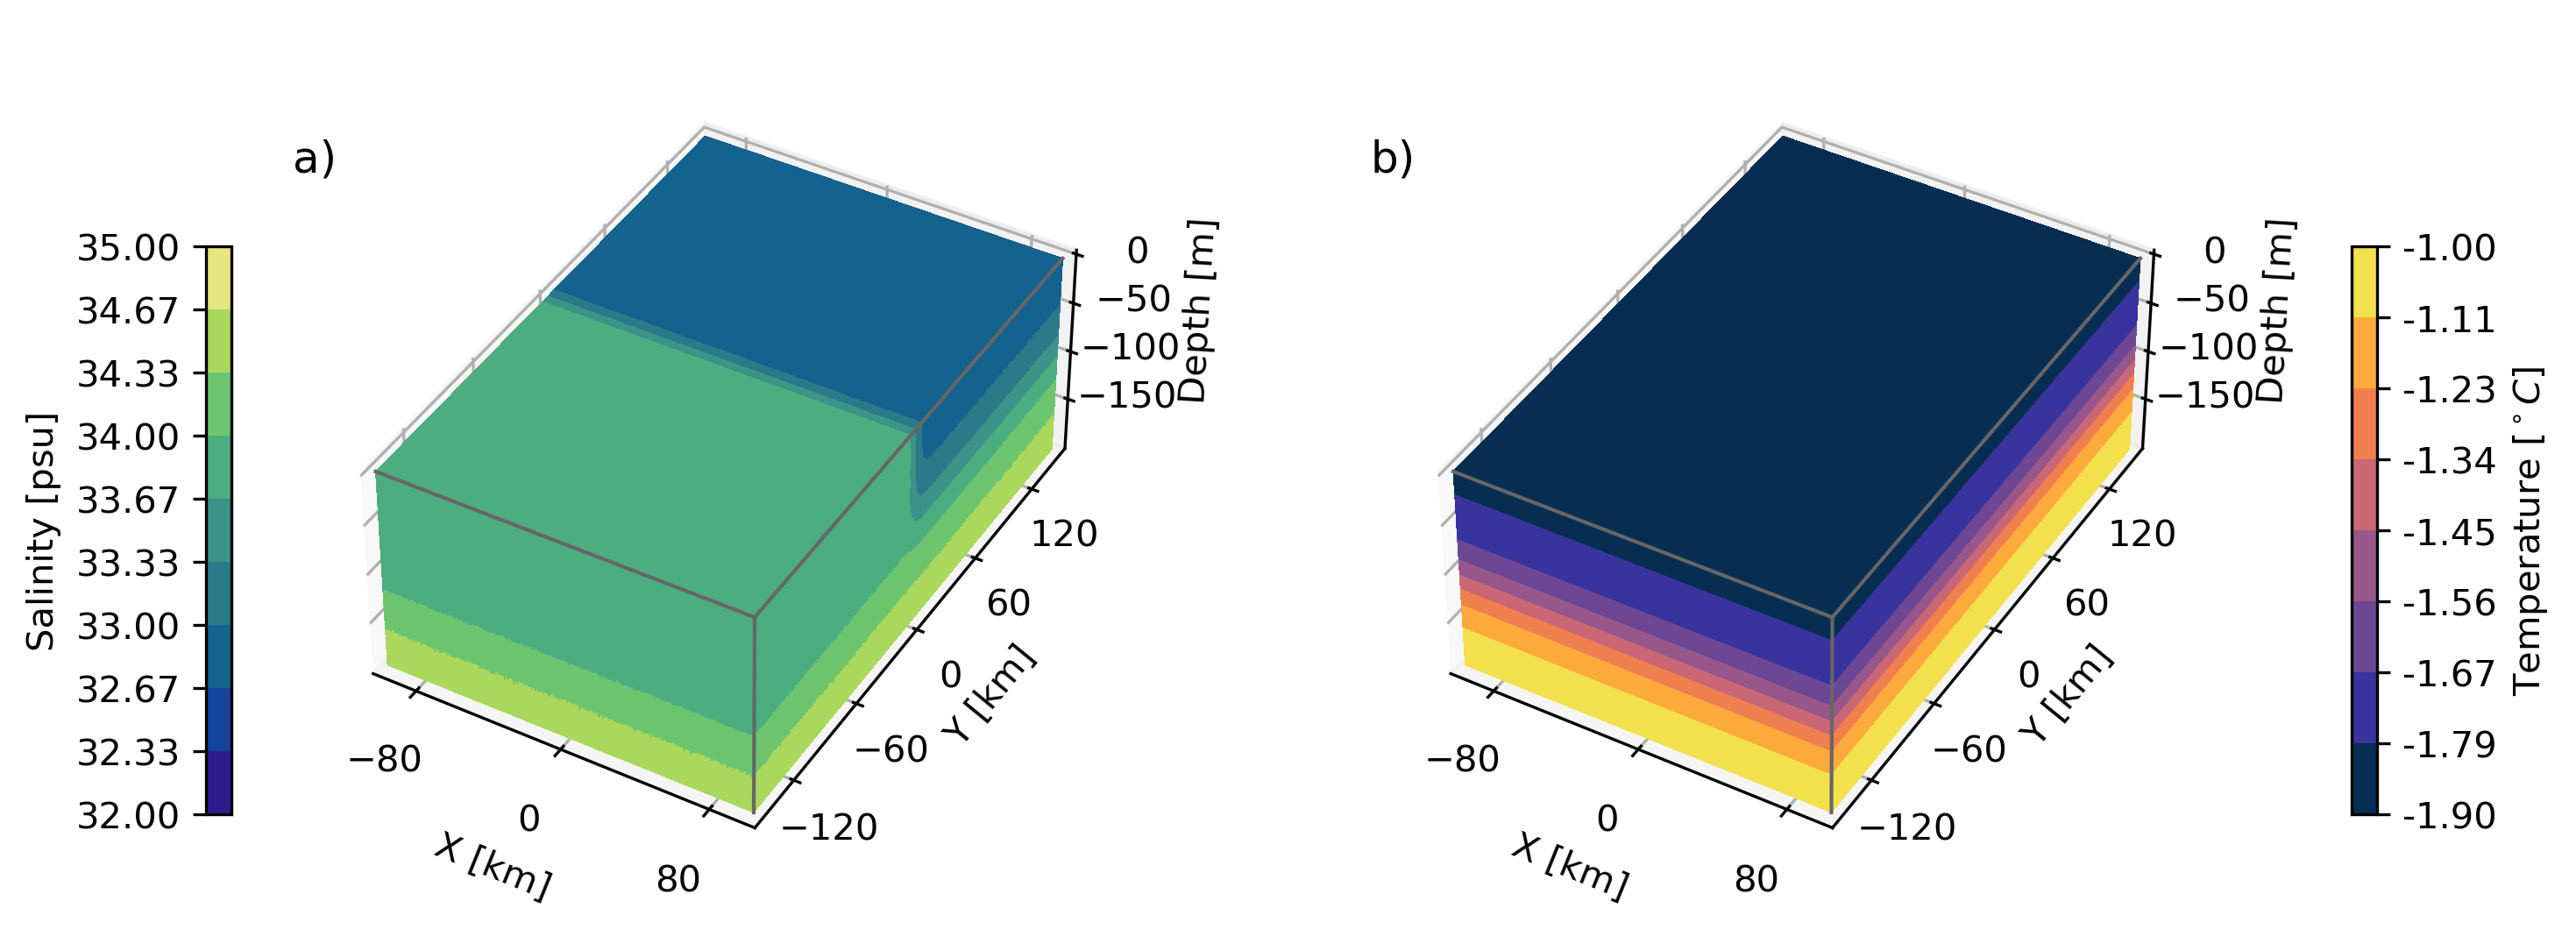

In [13]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(12, 12),dpi=300)


gs = GridSpec(16, 4, figure=fig)

########################################################################
ax1 = fig.add_subplot(gs[0:6, :2], projection='3d')

kw = {
    'vmin': 32,
    'vmax': 35,
    'levels': np.linspace(32,35,10),
    'cmap': cm.cm.haline,
}

# Plot contour surfaces
_t = ax1.contourf(
    X[:, :, 0], Y[:, :, 0], init_data_salt[:, :, 0].values,
    zdir='z', offset=0, **kw
)
_r = ax1.contourf(
    X[0, :, :], init_data_salt[1, :, :].values, Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)
C1 = ax1.contourf(
    init_data_salt[:, -1, :].values, Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)

# [contour_rasterize(c) for c in [_t, _r, C1] ]

########################################################################
ax2 = fig.add_subplot(gs[0:6, 2:], projection='3d')

kw = {
    'vmin': -1.9,
    'vmax': -1,
    'levels': np.linspace(-1.9,-1,9),
    'cmap': cm.cm.thermal,
}

# Plot contour surfaces
_t = ax2.contourf(
    X[:, :, 0], Y[:, :, 0], init_data_temp[:, :, 0].values,
    zdir='z', offset=0, **kw
)
_r = ax2.contourf(
    X[0, :, :], init_data_temp[1, :, :].values, Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)
C2 = ax2.contourf(
    init_data_temp[:, -1, :].values, Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)

# [contour_rasterize(c) for c in [_t, _r, C2] ]

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()


[format_3daxis(ax) for ax in [ax1,ax2]]


# Colorbar
cax = fig.add_axes([0.18, 0.63, 0.008, 0.18])
fig.colorbar(C1, cax=cax, format=ticker.FuncFormatter(myfmt))
cax.set_ylabel('Salinity [psu]')
cax.yaxis.set_ticks_position('left')
cax.yaxis.set_label_position('left')


cax = fig.add_axes([0.86, 0.63, 0.008, 0.18])
fig.colorbar(C2, cax=cax, format=ticker.FuncFormatter(myfmt))
cax.set_ylabel('Temperature [$^\circ C$]')


ax1.text2D(0.05, 0.85, 'a)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)
ax2.text2D(0.05, 0.85, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes,fontsize=12)


plt.subplots_adjust(hspace=0.25, wspace=-0.35)

# Save Figure
plt.savefig('./figures/Fig_2_init_conds.png', dpi=300, bbox_inches='tight')


**Figure 2.** Initial conditions for the idealized coupled sea ice-ocean configuration. a) Initial
ocean salinity with a fresher northern domain within the ML to develop baroclinic instabilities.
The salinity difference between the northern and southern half of the domain is 1 psu. b) Initial
ocean temperature representative of waters near the freezing point above a warmer subsurface
layer.